WARNING    OpenCV is not installed and cannot be used


CUDA enabled


INFO       Loading state from file [weights/yolov2-voc.pt]


4 0
tensor([4], device='cuda:0')
3 1
tensor([3], device='cuda:0')
4 0
tensor([4], device='cuda:0')
4 0
tensor([4], device='cuda:0')
4 0
tensor([4], device='cuda:0')
4 0
tensor([4], device='cuda:0')
4 0
tensor([4], device='cuda:0')
max: 0.056759767 , min: -0.081008196
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0


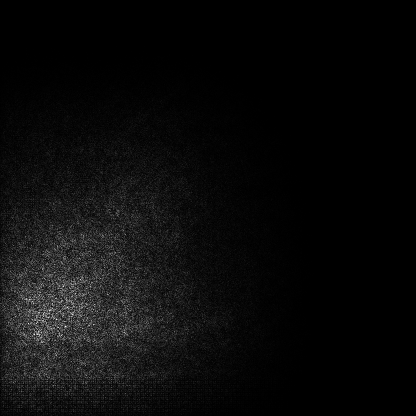

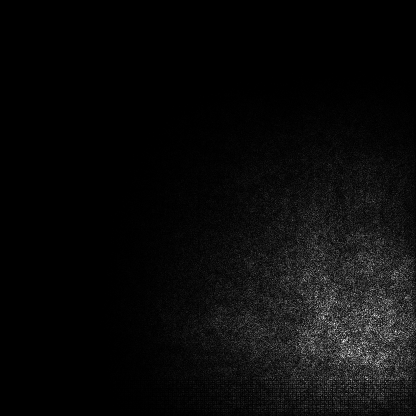

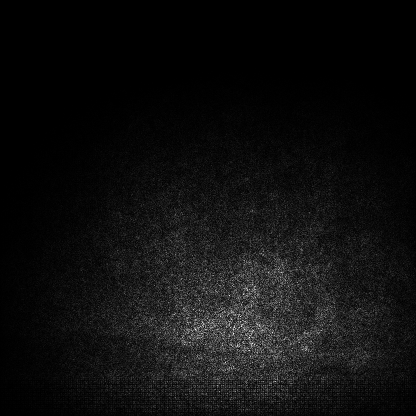

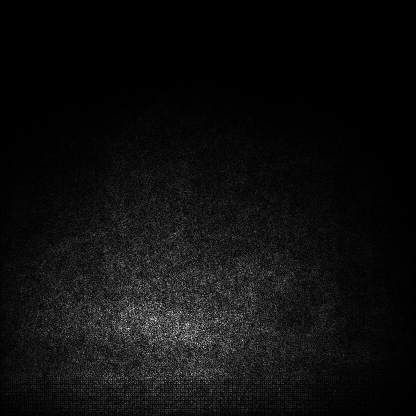

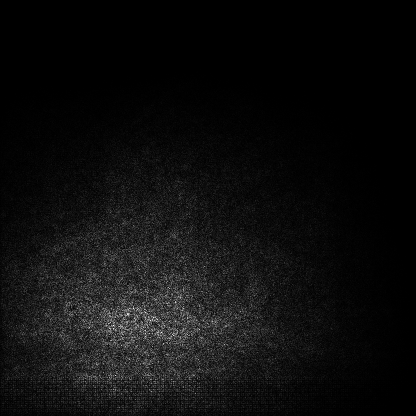

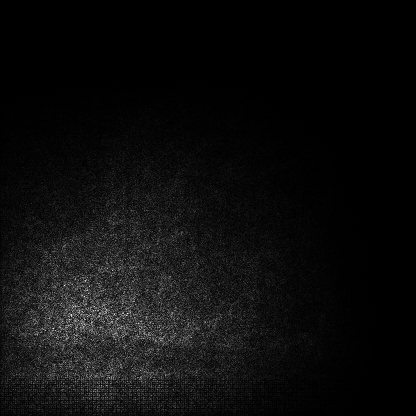

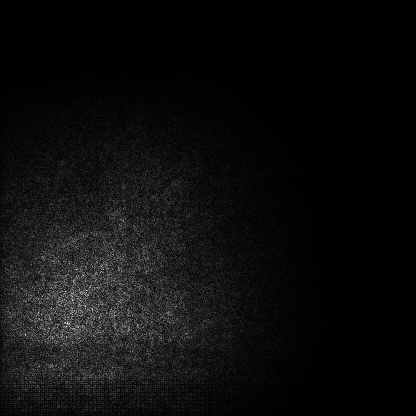

In [1]:
import torch
import brambox as bb
import lightnet as ln
import interpretability as ip

# Parse arguments
device = torch.device('cpu')
if torch.cuda.is_available():
    print('CUDA enabled')
    device = torch.device('cuda')
else:
    print('CUDA not available')
    
network_path = 'cfg/yolo.py'
annos_path = 'data/VOCdevkit/VOC2007/Annotations/000004.xml'
weights_path = 'weights/yolov2-voc.pt'
threshold = 0.0

params = ln.engine.HyperParameters.from_file(network_path)

params.load(weights_path)

annos = bb.io.load('anno_pascalvoc', annos_path, ip.identify)

# Run backpropagation
params, img_tf, annos = ip.detect_new(params, annos, annos_path, device)

# Vanilla backprop
VBP = ip.backprop.VanillaBackprop(params, device)
# Generate gradients
gradients_as_arr = VBP.generate_gradients(params, img_tf, annos, device, threshold)

# Normalize to grayscale
gradients_list = ip.utils.normalize(gradients_as_arr, True)

for gradient in gradients_list:
    display(ip.utils.show_image(gradient))